<a href="https://colab.research.google.com/github/ulissigroup/OfflineAL-for-MLPs-manuscript/blob/master/interactive_notebooks/offlineAL_neb_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Nudged Elastic Band through Offline Active Learning Demo
Using the proposed offline acitve learning framework to accelerate a NEB calculation to find the surface diffusion energy barrier of a Cu$_{12}$O system. EMT is used for performance but the option to use DFT through Quantum Espresso is also available.

### Installation of packages

In [11]:
!pip install -q git+https://github.com/saurabhsivakumar/amptorch.git@active_learning
!pip install -q git+https://github.com/mshuaibii/SIMPLE-NN.git
!pip install -q amp-atomistics
!pip install -q --upgrade dftbook

  ERROR: Failed building wheel for simple-nn


### Build the NEBcalculator class and construct geometry

In [12]:
import copy
import os
import numpy as np
import random

import torch

from amptorch.active_learning.learner import AtomisticActiveLearner
from amptorch.active_learning.query_methods import random_query, max_uncertainty,neb_query
from amptorch.active_learning.al_utils import CounterCalc, attach_sp_calc
from amptorch.model import CustomMSELoss

import ase
from ase.calculators.calculator import Calculator
from ase.calculators.emt import EMT
from ase.calculators.singlepoint import SinglePointCalculator as sp
from ase.optimize import QuasiNewton
from ase.neb import NEB, SingleCalculatorNEB
from ase.optimize import BFGS, FIRE, BFGSLineSearch
from ase import Atoms, Atom, units
from ase.build import molecule
from ase.visualize import view
from ase.io import read, write
from ase.io.trajectory import TrajectoryReader,Trajectory
from ase.build import fcc100, add_adsorbate,bcc100,fcc111
from ase.constraints import FixAtoms
from ase.neb import NEBTools

import dftbook
dftbook.setup_colab()
from espresso import Espresso

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 

import multiprocessing as mp
try:
  mp.set_start_method("spawn")
except:
  if mp.get_start_method() == "spawn":
    pass
  else:
    raise Exception('Wrong mp start method!')

Please be patient. This takes about 30 seconds.
Installing ASE
Installing ase-espresso
Installing pseudopotentials
Renaming pseudopotentials
Almost there, setting environment pseudopotential path
Installing quantum espresso
Setup is complete. Please visit https://github.com/jkitchin/dft-book-espresso to find the tutorials.
Installation took 10.1 seconds


**Important Note**: The QE colab calculator only works with some GPUs provided by the standard free colab. The GPU Tesla P100-PCIE GPU works best. The CPU runtime can be used well without any issues, but the training will be slower. For testing recommended calculator is EMT() and that is the default that has been set

In [13]:
class NEBcalc:
    def __init__(self, starting_images, ml2relax=True, intermediate_samples=3):
      """
      Computes a NEB given an initial and final image.

      Parameters
      ----------
      starting_images: list. Initial and final images to be used for the NEB.

      ml2relax: boolean. True to use ML to relax the initial and final structure guesses. 
      False if initial and final structures were relaxed beforehand.
      
      intermediate_samples: int. Number of intermediate samples to be used in constructing the NEB"""
      
      self.starting_images = copy.deepcopy(starting_images)
      self.ml2relax = ml2relax
      self.intermediate_samples = intermediate_samples
      
    def run(self, calc, filename):
      """
      Runs NEB calculations.
      Parameters
      ----------
      calc: object. Calculator to be used to run method.
      filename: str. Label to save generated trajectory files."""
      
      initial = self.starting_images[0].copy()
      final = self.starting_images[-1].copy()
      if self.ml2relax:
        # Relax initial and final images
        ml_initial = initial
        ml_initial.set_calculator(calc)
        ml_final = final
        ml_final.set_calculator(calc)
        print('BUILDING INITIAL')
        qn = BFGS(ml_initial, trajectory='initial.traj', logfile='initial_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        print('BUILDING FINAL')
        qn = BFGS(ml_final, trajectory='final.traj', logfile='final_relax_log.txt')
        qn.run(fmax=0.01, steps=100)
        initial = ml_initial.copy()
        final = ml_final.copy()

      initial.set_calculator(calc)
      final.set_calculator(calc)

      images = [initial]
      for i in range(self.intermediate_samples):
        image = initial.copy()
        image.set_calculator(calc) 
        images.append(image)
      images.append(final)

      print('NEB BEING BUILT')
      neb = SingleCalculatorNEB(images)
      neb.interpolate()
      print('NEB BEING OPTIMISED')
      opti = BFGS(neb, trajectory=filename+".traj", logfile='al_neb_log.txt')
      opti.run(fmax=0.01, steps=100)
      print('NEB DONE')

      """ 
      The following code is used to visualise the NEB at every iteration 
      """
      
      built_neb = NEBTools(images)
      barrier, dE = built_neb.get_barrier()
      max_force = built_neb.get_fmax()
      fig = built_neb.plot_band()
      plt.show()
      
    def get_trajectory(self, filename):
      atom_list = []
      trajectory = ase.io.Trajectory(filename + ".traj")
      for atom in trajectory:
          atom_list.append(atom)
      return atom_list

In [14]:
#https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html#diffusion-tutorial
#Surface Diffusion Energy Barriers
#Building your structure

def construct_geometries(parent_calc, ml2relax):
  counter_calc = CounterCalc(parent_calc,"parent_database")
  # Initial structure guess
  initial_slab = fcc100('Cu', size=(2, 2, 3))
  add_adsorbate(initial_slab, 'O', 1.7, 'hollow')
  initial_slab.center(axis=2, vacuum=4.0)
  mask = [atom.tag > 1 for atom in initial_slab]
  initial_slab.set_constraint(FixAtoms(mask=mask))

  initial_slab.set_calculator(counter_calc)

  # Final structure guess
  final_slab = initial_slab.copy()
  final_slab[-1].x += final_slab.get_cell()[0, 0] / 3
  final_slab.set_calculator(counter_calc)

  if not ml2relax:
    print('BUILDING INITIAL')
    qn = BFGS(initial_slab, trajectory='initial.traj', logfile='initial_relax_log.txt')
    qn.run(fmax=0.01, steps=100)
    print('BUILDING FINAL')
    qn = BFGS(final_slab, trajectory='final.traj', logfile='final_relax_log.txt')
    qn.run(fmax=0.01, steps=100)
    initial_slab = read("initial.traj", "-1")
    final_slab = read("final.traj", "-1")
    #If there is already a pre-existing initial and final relaxed parent state we can read that to use as a starting point
    #initial_slab = read("/content/parent_initial.traj")
    #final_slab = read("/content/parent_final.traj")
  else:
    initial_slab = attach_sp_calc(initial_slab)
    final_slab = attach_sp_calc(final_slab)

  initial_force_calls = counter_calc.force_calls
  return initial_slab, final_slab, initial_force_calls

###Define model parameters and settings for ML+Morse run

Modify the following arguments to explore the alternative query + termination strategies (Default is set to the neb_strat):

Random:
```
"al_convergence": {"method": "iter", "num_iterations": 7,"energy_tol":0.01,"convergence_check":False},
"samples_to_retrain": 3,
ensemble=False
query_strategy=random_query
```
**Note:** Setting convergence_check to True will result in early termination if the difference in energy at saddle points calculated via ML and DFT is below the energy_tol

NEB querying strat + early termination:
```
"al_convergence": {"method": "neb_iter", "num_iterations": 7,"energy_tol":0.01},
"samples_to_retrain": 3,
ensemble=False
query_strategy=neb_query
```
Uncertainty + early termination:
```
"al_convergence": {"method": "iter", "num_iterations": 7,"energy_tol":0.01,"convergence_check":True},
"samples_to_retrain": 3,
ensemble=2 
query_strategy=max_uncertainty
```
**Note**: Google Colab is limited to 2 CPUs so this may not be efficiently parallelized here.

#### Setting the Calculator

In [15]:
emt_calc = EMT()
dft_calc = Espresso(
    pw=500.0, 
    calculation='scf',
    kpts=(4,4,1),
    xc='PBE'
)
base_calc = emt_calc

#### Active learning Framework

In [16]:
force_calls = []
ml2relax = True #use machine learning to relax the initial and final states rather than DFT as is the norm
total_neb_images = 5  # N + 2 where N is the number of intermediate images and 2 is for initial and final structures
initial, final, initial_force_calls = construct_geometries(parent_calc=base_calc, ml2relax=ml2relax)
def main():
    
    # Define symmetry functions
    Gs = {}
    Gs["G2_etas"] = np.logspace(np.log10(0.05), np.log10(5.0), num=4)
    Gs["G2_rs_s"] = [0] * 4
    Gs["G4_etas"] = [0.005]
    Gs["G4_zetas"] = [1.0, 4.0]
    Gs["G4_gammas"] = [+1.0, -1]
    Gs["cutoff"] = 6.0

    # Training parameters for the active learning framework
    training_params = {
        "al_convergence":{"method": "neb_iter", "num_iterations": 7,"energy_tol":0.01},
        "samples_to_retrain": 3,
        "Gs": Gs,
        "morse": True,
        "forcetraining": True,
        "cores": 1,
        "optimizer": torch.optim.LBFGS,
        "batch_size": 1000,
        "criterion": CustomMSELoss,
        "num_layers": 3,
        "num_nodes": 20,
        "force_coefficient": 0.04,
        "learning_rate": 1e-2,
        "epochs": 200,
        "test_split": 0,
        "shuffle": False,
        "verbose": 1,
        "filename": "neb_ml_only_ml2relax_True",
        "file_dir": "./",
        "scheduler": {"policy": "CosineAnnealingWarmRestarts", "params":{"T_0":10, "T_mult":2}}
    }

    images = [initial]
    images.append(final)

    # Define AL scheme

    learner = AtomisticActiveLearner(
        training_data=images,
        training_params=training_params,
        convergence_func = 'neb_convergence',
        parent_calc=base_calc,
        ensemble=False
    )

    # Learn the corresponding atomistic method

    learner.learn(
        atomistic_method=NEBcalc(
            starting_images=images, 
            ml2relax=ml2relax, 
            intermediate_samples=3),
        query_strategy = neb_query
    )
    force_calls.append(initial_force_calls+learner.parent_calls)

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          0.0018          3.9036    95132.0234     +  0.1134
      2          0.0010          3.2383    65468.5820     +  0.1104


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0010          3.2067    64196.8086     +  0.1388
      4          0.0010          3.1966    63794.4570     +  0.1342
      5          0.0010          3.1928    63642.6797     +  0.1660
      6          0.0015          3.1828    63244.6523     +  0.1651
      7          0.0069          3.1481    61877.2070     +  0.1565
      8          0.0104          1.8724    21905.1406     +  0.1531
      9          0.0157          1.1642     8500.5498     +  0.1596
     10          0.0156          1.0042     6333.5430     +  0.1605
     11          0.0152          0.9441     5600.6729     +  0.1635
     12          0.0149          0.9276     5406.4219     +  0.1378
     13          0.0149          0.9276     5406.2017     +  0.1488
     14          0.0055          0.5392     1819.5688     +  0.1578
     15          0.0011          0.3871      935.8351     +  0.1515
     16          0.0027          0.3590      805.9894     +  0.1560
     17          0.0047          0.3536      784

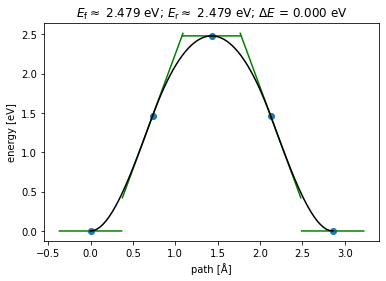

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.2586          5.1734        2.3607     +  0.1405
      2          0.2613          1.9190        0.0825     +  0.1445


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      3          0.0699          1.5505        0.0387     +  0.1959
      4          0.0786          1.2905        0.0278     +  0.1842
      5          0.0331          0.8884        0.0125     +  0.1933
      6          0.0249          0.6541        0.0068     +  0.2064
      7          0.0327          0.5139        0.0044     +  0.2047
      8          0.0213          0.4170        0.0028     +  0.2010
      9          0.0111          0.3442        0.0019     +  0.1942
     10          0.0073          0.3025        0.0014     +  0.1986
     11          0.0060          0.2806        0.0012     +  0.1949
     12          0.0056          0.2702        0.0011     +  0.1938
     13          0.0056          0.2702        0.0011     +  0.2032
     14          0.0051          0.1410        0.0003     +  0.1894
     15          0.0049          0.0997        0.0002     +  0.1931
     16          0.0048          0.0774        0.0001     +  0.2070
     17          0.0043          0.0631        0

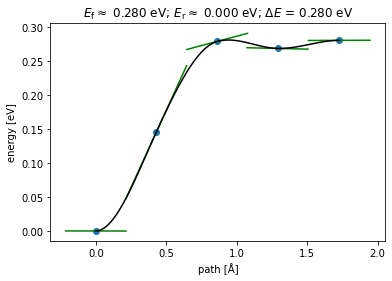

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.2256          4.8211        4.2634     +  0.1781


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.3355          1.7468        0.1700     +  0.2011
      3          0.0700          1.3760        0.0584     +  0.2108
      4          0.0454          1.1748        0.0415     +  0.2299
      5          0.0346          0.8073        0.0198     +  0.2308
      6          0.0168          0.6024        0.0107     +  0.2357
      7          0.0124          0.4346        0.0056     +  0.2361
      8          0.0079          0.3732        0.0041     +  0.2494
      9          0.0063          0.3287        0.0032     +  0.2371
     10          0.0067          0.2932        0.0025     +  0.2378
     11          0.0068          0.2722        0.0022     +  0.2339
     12          0.0067          0.2667        0.0021     +  0.1602
     13          0.0067          0.2667        0.0021     +  0.2402
     14          0.0049          0.1891        0.0011     +  0.2448
     15          0.0039          0.1721        0.0009     +  0.2336
     16          0.0029          0.1567        0

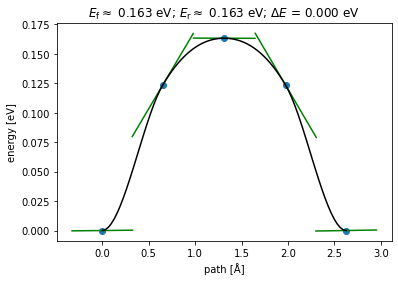

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          2.0465          4.7742        6.4264     +  0.2154


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2971          1.5616        0.2342     +  0.2356
      3          0.0692          1.1611        0.0740     +  0.2512
      4          0.0520          0.9576        0.0496     +  0.2519
      5          0.0326          0.5877        0.0188     +  0.2707
      6          0.0094          0.4493        0.0103     +  0.2773
      7          0.0045          0.3695        0.0069     +  0.2826
      8          0.0057          0.3251        0.0054     +  0.2804
      9          0.0062          0.2879        0.0042     +  0.2707
     10          0.0058          0.2596        0.0034     +  0.2766
     11          0.0054          0.2449        0.0031     +  0.2751
     12          0.0052          0.2415        0.0030     +  0.1423
     13          0.0052          0.2415        0.0030     +  0.2862
     14          0.0026          0.1993        0.0020     +  0.2717
     15          0.0016          0.1879        0.0018     +  0.2739
     16          0.0028          0.1779        0

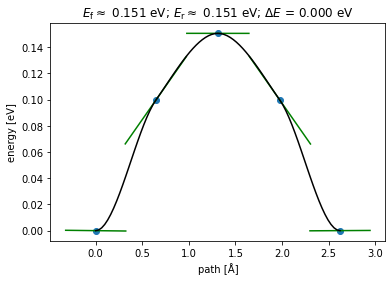

Calculating fingerprints...
Fingerprints Calculated!
  epoch    energy_score    forces_score    train_loss    cp     dur
-------  --------------  --------------  ------------  ----  ------
      1          1.7736          4.3445        7.6501     +  0.2558


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


      2          0.2838          1.3965        0.3109     +  0.2878
      3          0.0599          1.0704        0.0969     +  0.2858
      4          0.0334          0.7685        0.0485     +  0.2963
      5          0.0204          0.5168        0.0218     +  0.3093
      6          0.0065          0.4053        0.0130     +  0.3275
      7          0.0048          0.3431        0.0093     +  0.3250
      8          0.0049          0.2971        0.0070     +  0.3247
      9          0.0043          0.2575        0.0052     +  0.3213
     10          0.0045          0.2388        0.0045     +  0.3161
     11          0.0045          0.2303        0.0042     +  0.3172
     12          0.0045          0.2280        0.0041     +  0.1642
     13          0.0045          0.2280        0.0041     +  0.3131
     14          0.0037          0.1835        0.0027     +  0.3194
     15          0.0035          0.1714        0.0023     +  0.3102
     16          0.0046          0.1602        0

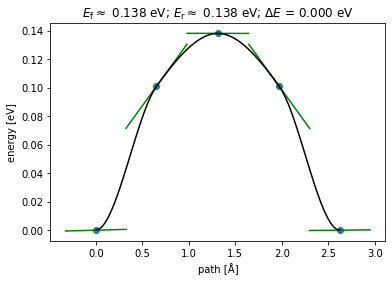

Terminating! Convergence criteria has been met


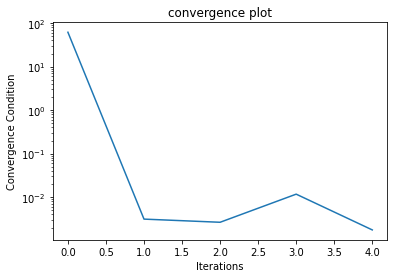

[61.78386525710849, 0.0031230482459587705, 0.0026425507190732667, 0.011708207184874198, 0.0017628280843116073]


In [17]:
if __name__ == "__main__":
  main()

In [18]:
print('The base calculator calls for the active-learning framework is:',force_calls)

The DFT calls for the active-learning framework is: [17]


### Code to generate true NEB

The following code is meant to be run seperately in order to identify the NEB that is built purely using DFT or EMT

**Note:** If using dft this will take a long time

In [19]:
main_counter = CounterCalc(base_calc,"base_calc_database")
if not ml2relax:
  # Load previously computed relaxed states
  initial_slab1 = read("initial.traj", "-1")
  final_slab1 = read("final.traj", "-1")
else:
  initial.set_calculator(main_counter)
  final.set_calculator(main_counter)
  qn = BFGS(initial, trajectory='original_parent_initial.traj', logfile='original_initial_relax_log.txt')
  qn.run(fmax=0.05, steps=200)
  qn = BFGS(final, trajectory='original_parent_final.traj', logfile='original_final_relax_log.txt')
  qn.run(fmax=0.05, steps=200)
  initial_slab1 = read("original_parent_initial.traj", "-1")
  final_slab1 = read("original_parent_final.traj", "-1")

images2 = [initial_slab1]
for i in range(total_neb_images - 2):
    image = final_slab1.copy()
    image.set_calculator(main_counter)
    images2.append(image)
images2.append(final_slab1)

neb = SingleCalculatorNEB(images2)
neb.interpolate()
qn = BFGS(neb, trajectory='actual_neb1.traj')
qn.run(fmax=0.01,steps = 100)

      Step     Time          Energy         fmax
BFGS:    0 04:21:21        4.229320        4.3343
BFGS:    1 04:21:22        3.849664        2.2293
BFGS:    2 04:21:22        3.715498        0.6594
BFGS:    3 04:21:22        3.704678        0.4160
BFGS:    4 04:21:22        3.693892        0.4596
BFGS:    5 04:21:23        3.677048        0.3789
BFGS:    6 04:21:23        3.665180        0.2782
BFGS:    7 04:21:23        3.661645        0.1750
BFGS:    8 04:21:23        3.660653        0.1811
BFGS:    9 04:21:23        3.658890        0.1544
BFGS:   10 04:21:24        3.656454        0.1086
BFGS:   11 04:21:24        3.655391        0.0972
BFGS:   12 04:21:24        3.655295        0.0735
BFGS:   13 04:21:24        3.655134        0.0597
BFGS:   14 04:21:25        3.654960        0.0228
BFGS:   15 04:21:25        3.654928        0.0093


True

Ef = 0.12944990476420504, dE = 0.0006439577041437161, force = 0.009339014890301844
Total number of force calls = 95


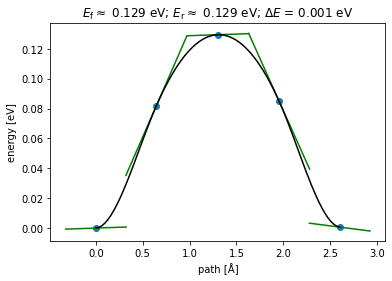

In [20]:
images = read(f'actual_neb1.traj@-{total_neb_images}:')
nebtools = NEBTools(images)

Ef, dE = nebtools.get_barrier(fit=False)
force = nebtools.get_fmax()

print(f"Ef = {Ef}, dE = {dE}, force = {force}")
print(f"Total number of force calls = {initial_force_calls+main_counter.force_calls}")

fig = nebtools.plot_band()
fig.savefig('original_diffusion-barrier.png')